<a href="https://colab.research.google.com/github/muxeres/PNL/blob/master/%5BONLINE%5D_Classifica%C3%A7%C3%A3o_de_textos_An%C3%A1lise_de_Sentimentos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificação de textos - Análise de Sentimentos
## Processamento de Linguagem Natural
Nesta aula continuaremos trabalhando com Classificação de textos, porém agora focaremos em uma tarefa específica, chamada de **Análise de Sentimentos**.

O objetivo é que ao final desta aula você:
1. Entenda o que é a **Análise de Sentimentos**
2. Saiba treinar um classificador supervisionado para realizar análise de sentimentos usando um corpus anotado
3. Aprenda a utilizar a biblioteca Polyglot do Python que já possui métodos para identificar polaridade de textos em português
4. Acesse API do Twitter para obter dados em tempo real de redes sociais




### **O que é a Análise de Sentimentos?**

É a interpretação e classificação de emoções relativas a um texto, sendo estas emoções explícitas declaradas no texto ou implícitas.

![Análise de sentimentos. Fonte: https://monkeylearn.com/sentiment-analysis/](https://docs.google.com/uc?export=download&id=1okG1oHXPhnZiBBTtpZG4b3VdaWovCndT)

É uma tarefa de PLN/Machine Learning que permite empresas identificarem os sentimentos dos consumidores em relação a produtos, marcas ou serviços, através de opiniões deixadas em redes sociais ou em canais de comunicação da empresa.


















### **Como treinar um classificador para realizar a Análise de Sentimentos?**
Iremos desenvolver nosso classificador, utilizando uma abordagem supervisionada, ou seja, precisaremos de dados rotulados com suas respectivas emoções.

O pipeline de execução é muito similar aos exemplos de classificação realizados na última semana, o que muda efetivamente são as classes/categorias envolvidas.

#### Dados
Para este exemplo iremos trabalhar com uma [base de dados de notícias](https://www.aclweb.org/anthology/W15-5616.pdf), rotulada com as emoções básicas de [Ekman](https://www.tandfonline.com/doi/abs/10.1080/02699939208411068): **alegria**, **tristeza**, **raiva**, **medo**, **repugnância** e **surpresa**. Em caso de ausência de emoção, a categoria **neutro** foi aplicada.



> **IMPORTANTE**: Faça o upload da base de dados para seu ambiente Google Colab ou Jupyter Notebook! Segue o [link](https://drive.google.com/file/d/12-mbbvHtnDVRTbQnhmOfnIXppbQ0hoyn/view?usp=sharing) para acesso.



#### Fluxo de execução
Vamos seguir o seguinte fluxo de processamento dos dados:


1.   Abrir o corpus
2.   Remover as stop-words
3.   Aplicar stemmer
4.   Gerar o Bag of Words
5.   Treinar o modelo SVM
6.   Predizer/Avaliar o modelo



In [123]:
# Abre corpus
f = open("analise-sentimentos-2000-noticias.txt", "r", encoding="utf-8-sig")
linhas = f.readlines()

corpus_textos = []
corpus_rotulos = []

# Percorre as 2000 linhas
for linha in linhas:

  # Separa texto e rótulo/categoria/emoção
  item = linha.split(";;")

  corpus_rotulos.append(item[0])
  corpus_textos.append(item[1])

In [124]:
# 5 primeiros textos
corpus_textos[0:5]

['irã liberta viúva condenada ao apedrejamento, diz comitê internacional. a viúva iraniana sakineh mohammadi-ashtiani, condenada à morte por apedrejamento, foi libertada juntamente com o seu filho e o seu advogado, anunciou nesta quinta-feira (9) o comitê internacional contra apedrejamento, sediado na alemanha.\n',
 'haiti sofre com cólera depois da passagem do furacão sandy. após a passagem do furacão sandy pelo haiti, o país vive as dificuldades da reconstrução, além de problemas causados pela contaminação da bactéria que causa o cólera.\n',
 'mulher acorda e encontra crocodilo de 3 m e 27 ovos no jardim de casa. especialistas capturaram e transferiram animal para local adequado.\n',
 'enchentes causam a morte de 4 pessoas em al: vítimas são mãe, filho, idosa de 100 anos e adolescente. defesa civil da capital já registrou mais de 30 ocorrências.\n',
 'sem detalhes do que será discutido, revisão do plano diretor começa na segunda (17). dez oficinas, 19 audiências públicas e canal inte

In [125]:
# 5 primeiros rótulos
corpus_rotulos[0:5]

['alegria', 'tristeza', 'surpresa', 'tristeza', 'neutro']

Em nossos exemplos de classificação anteriores, separamos parte do banco de dados para **TREINAMENTO** e outra parte para **TESTE**, nesse tipo de avaliação que chamamos de **hold-out**.

Existem outras formas de realizar a avaliação, inclusive mais indicadas de acordo com a situação, mas isto não está no escopo de nossa disciplina, caso queira saber mais métodos de avaliação como o **cross-validation**, leia [este post](https://medium.com/@eijaz/holdout-vs-cross-validation-in-machine-learning-7637112d3f8f).

In [126]:
from sklearn.model_selection import train_test_split

# O próprio sklearn tem um método para dividir a base de dados em treinamento e teste
# Neste caso estamos deixando 90% para treinamento e 10% para testes
corpus_treinamento, corpus_teste, rotulos_treinamento, rotulos_teste = train_test_split(corpus_textos, corpus_rotulos, test_size=0.10, random_state=42)

In [127]:
len(corpus_treinamento)

1800

In [128]:
len(corpus_teste)

200

In [129]:
len(rotulos_treinamento)

1800

In [130]:
len(rotulos_teste)

200

Vamos deixar preparada uma função para pré-processar os textos, utilizando uma lista de stop-words com novos itens, o stemming e normalização dos textos.

In [131]:
import nltk
from nltk import tokenize
nltk.download('stopwords')
nltk.download('rslp')
nltk.download('punkt')

stopwords = nltk.corpus.stopwords.words('portuguese') #carrega stopwords da lingua portuguesa disponíveis no NLTK
stopwords += (',','.','(',')','"',"'",'´','`','!','$','%','&','...','-',':',';','?','``','\'\'') #acrescenta simbolos
stopwords += ('a','e','i','o','u','A','E','I','O','U') #acrescenta também vogais

stemmer = nltk.stem.RSLPStemmer()

def my_preprocessor(text):

    # Normaliza para minúsculas
    text=text.lower()

    # Tokeniza
    words = tokenize.word_tokenize(text, language='portuguese')
    # Remove stop-words
    words_no_stopwords = [word for word in words if not word in stopwords]
    # Aplica stemming
    stemmed_words=[stemmer.stem(word=word) for word in words_no_stopwords]
    return ' '.join(stemmed_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Agora vamos extrair os atributos do texto (gerar a representação vetorial - bag of words) e criar nosso pipeline de classificação usando o classificador SVM.

In [132]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer

# Primeiro aplica o BoW, depois envia dados ao classificador SVM
# (SEM retirada de stop-words e stemming)
sent_clf = Pipeline([('vect', CountVectorizer()),('clf', SVC(kernel='linear', C=1))])

# Depois de executar uma vez, verifique os resultados e compare-os depois de descomentar a linha abaixo, onde retiramos as stop-words e aplicamos stemming
# (COM retirada de stop-words e stemming)
#sent_clf = Pipeline([('vect', CountVectorizer(preprocessor = my_preprocessor)),('clf', SVC(kernel='linear', C=1))])

In [133]:
# Inicia treinamento
sent_clf = sent_clf.fit(corpus_treinamento, rotulos_treinamento)

Já temos nosso modelo treinado! Agora vamos predizer a base de teste e avaliar os resultados.

In [134]:
# Prediz base de teste
rotulos_preditos = sent_clf.predict(corpus_teste)

In [135]:
from sklearn.metrics import classification_report

# Mostra relatório completo de avaliação
print(classification_report(rotulos_teste, rotulos_preditos))

              precision    recall  f1-score   support

     alegria       0.00      0.00      0.00        19
    desgosto       0.44      0.26      0.33        27
        medo       0.32      0.39      0.35        18
      neutro       0.52      0.73      0.61        51
       raiva       0.29      0.29      0.29         7
    surpresa       0.42      0.47      0.44        32
    tristeza       0.66      0.59      0.62        46

    accuracy                           0.47       200
   macro avg       0.38      0.39      0.38       200
weighted avg       0.45      0.47      0.45       200



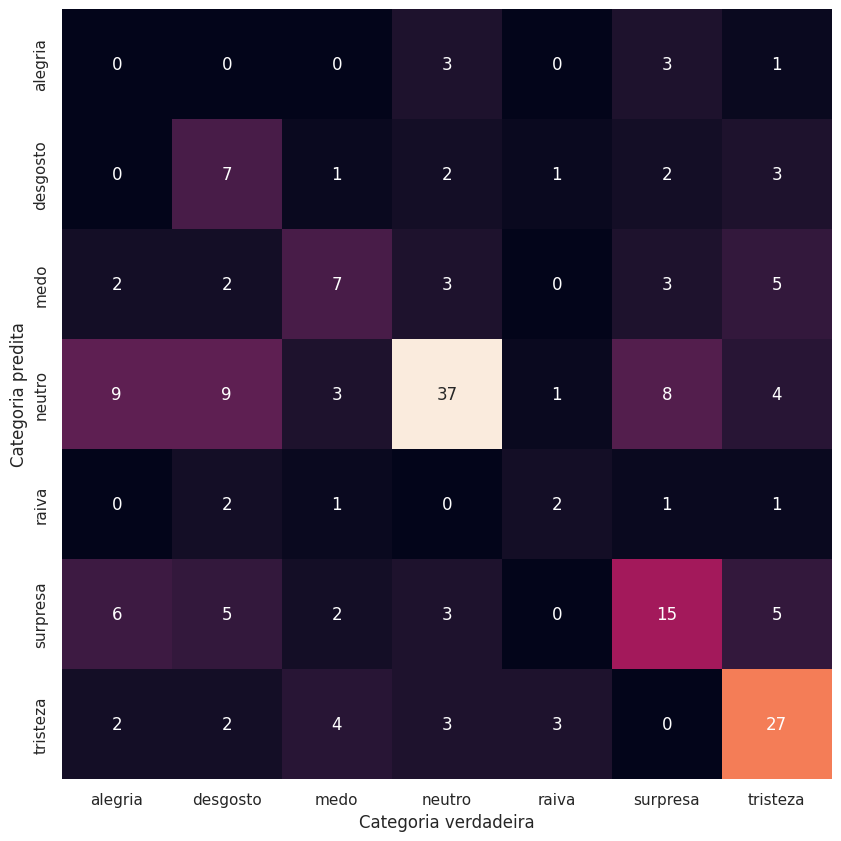

In [136]:
from sklearn.metrics import confusion_matrix

# Podemos imprimir a matriz de confusão para tentar entender melhor os resultados
mat = confusion_matrix(rotulos_teste, rotulos_preditos)

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

rotulos_nomes = ['alegria', 'desgosto', 'medo', 'neutro', 'raiva', 'surpresa', 'tristeza']

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=rotulos_nomes, yticklabels=rotulos_nomes )
plt.xlabel('Categoria verdadeira')
plt.ylabel('Categoria predita');

> **CONCLUSÃO**: Apesar de verificarmos melhoria ao pré-processarmos o texto, os resultados ainda são regulares.

#### **Atividade Somativa 2 - Como podemos tentar melhorar os resultados?**

**1) Redução da granularidade dos sentimentos**
Como podemos ver na matriz de confusão o classificador tem vários pontos de erro, em todas emoções. E se modificarmos o corpus para ao invés de 7 emoções, trabalhar com as 3 clássicas (positivo, neutro, negativo)?

Vamos então adotar a seguinte sistemática de atualização da base de dados:

A classe "**positivo**" será obtida utilizando-se as instâncias da base original rotuladas como "alegria".

A classe "**negativo**" será obtida utilizando-se as instâncias rotuladas como "raiva", "medo", "desgosto" e "tristeza".

Já a classe "**neutro**", utilizará as instâncias da base original rotuladas como "neutro".

As instâncias rotuladas como "surpresa" não serão utilizadas.

Crie um novo arquivo para esta base de dados atualizada, carregue-o em nosso notebook e compare os resultados.

**2) Configuração dos parâmetros de extração de atributos e do classificador**
Altere a configuração de pelo menos um atributo gerado pela vetorização das palavras (i.e., CountVectorizer) e também pelo classificador utilizado.

**3) Adicione novas etapas de extração de atributos ou de pré-processamento**
Incorpore ao menos uma nova etapa de pré-processamento ou extração de atributos (e.g., TF-IDF) ao pipeline atual.

**4) Utilize outro classificador de texto**
Treine ao menos um novo modelo utilizando um classificador de textos diferentes. Ele pode pertencer à biblbioteca sklearn ou qualquer outra.



### **Existe alguma ferramenta pronta que realize análise de sentimentos?**
Não é sempre que teremos um corpus anotado para utilizar em nossas tarefas, neste caso, existem bibliotecas que incorporam funcionalidades simples que podem ser usadas para detectar a polaridade de textos (negativo, positivo).

No caso da língua portuguesa, a [Polyglot](https://polyglot.readthedocs.io/en/latest/index.html) tem um léxico de polaridade das palavras, que pode ser usado para detecção simples de sentimentos.

In [137]:
# Ela tem algumas dependências que devem ser instaladas
!pip install -U git+https://github.com/aboSamoor/polyglot.git@master

  Cloning https://github.com/aboSamoor/polyglot.git (to revision master) to /tmp/pip-req-build-9vqnwmr8
  Running command git clone --filter=blob:none --quiet https://github.com/aboSamoor/polyglot.git /tmp/pip-req-build-9vqnwmr8
  Resolved https://github.com/aboSamoor/polyglot.git to commit 9b93b2ecbb9ba1f638c56b92665336e93230646a
  Preparing metadata (setup.py) ... done


In [138]:
import polyglot
from polyglot.text import Text
# Baixa o léxicos da lingua portuguesa
!polyglot download LANG:pt

[polyglot_data] Downloading collection 'LANG:pt'
[polyglot_data]    | 
[polyglot_data]    | Downloading package sgns2.pt to
[polyglot_data]    |     /root/polyglot_data...
[polyglot_data]    |   Package sgns2.pt is already up-to-date!
[polyglot_data]    | Downloading package unipos.pt to
[polyglot_data]    |     /root/polyglot_data...
[polyglot_data]    | Downloading package ner2.pt to
[polyglot_data]    |     /root/polyglot_data...
[polyglot_data]    |   Package ner2.pt is already up-to-date!
[polyglot_data]    | Downloading package counts2.pt to
[polyglot_data]    |     /root/polyglot_data...
[polyglot_data]    |   Package counts2.pt is already up-to-date!
[polyglot_data]    | Downloading package transliteration2.pt to
[polyglot_data]    |     /root/polyglot_data...
[polyglot_data]    |   Package transliteration2.pt is already up-to-
[polyglot_data]    |       date!
[polyglot_data]    | Downloading package embeddings2.pt to
[polyglot_data]    |     /root/polyglot_data...
[polyglot_da

In [139]:
text = Text("O filme que vimos é realmente muito bom!")
print("{:<16}{}".format("Word", "Polarity")+"\n"+"-"*30)
for w in text.words:
    print("{:<16}{:>2}".format(w, w.polarity))

Word            Polarity
------------------------------
O                0
filme            0
que              0
vimos            0
é                0
realmente        0
muito            1
bom              1
!                0


In [140]:
text = Text("As notas foram ruins.")
print("{:<16}{}".format("Word", "Polarity")+"\n"+"-"*30)
for w in text.words:
    print("{:<16}{:>2}".format(w, w.polarity))

Word            Polarity
------------------------------
As               0
notas            0
foram            0
ruins           -1
.                0


In [141]:
text = Text("Não sei o que pensar.")
print("{:<16}{}".format("Word", "Polarity")+"\n"+"-"*30)
for w in text.words:
    print("{:<16}{:>2}".format(w, w.polarity))

Word            Polarity
------------------------------
Não              0
sei              0
o                0
que              0
pensar           0
.                0


### **Como obter dados em tempo real de redes sociais?**
Já vimos na disciplina que é possível utilizar o web-scraping para obter páginas da web e percorrer a estrutura HTML em busca das informações. Porém, em alguns casos temos opções mais rápidas e viáveis para recolher dados. Alguns sites oferecem o serviço de [API](https://canaltech.com.br/software/o-que-e-api/) para acesso aos dados, onde podemos autenticar e utilizar funções para buscar dados em tempo real.

Em nosso exemplo, utilizaremos a [API do Twitter](https://developer.twitter.com/en/docs) para buscar tweets sobre determinado assunto.

Neste exemplo, utilizaremos as chaves de acesso da conta do professor, mas quando você for desenvolver seu script, você deve criar seu próprio token de acesso. Basta acessar sua conta no Twitter, na [página do desenvolvedor](https://developer.twitter.com/en/docs) você deve ir em Apps > Create an app.


In [142]:
# import tweepy
# from tweepy import OAuthHandler

# # As chaves e tokens que você receberá ao criar um App
# consumer_key = 'iUpbJiOv2LGFZdRTSqOOFndf7'
# consumer_secret = 'AVQQS4UcSI6dlRkwO3PdrNo6Iuwl9k5yE4oae18yNvACnhREzs'
# access_token = '12948382-GTwHQSlj2ylAsMxsm2TT8ecYQ8fUteAfNGTqJutAP'
# access_token_secret = 'U1HOAmQWkSwfiGEacEqDL59QZ8dvpBhG03yiusjyhtI2M'

# api = None
# try:
#   # Cria um objeto de autenticação (OAuthHandler)
#   auth = OAuthHandler(consumer_key, consumer_secret)
#   # Define o token e senha de acesso
#   auth.set_access_token(access_token, access_token_secret)
#   # Cria um novo objeto API para acessar os tweets
#   api = tweepy.API(auth)
# except:
#   print("Erro: Falha de autenticação no Twitter")

Uma vez que temos um objeto API autenticado, podemos fazer nossas buscas. A API oferecer vários métodos e parâmetros para buscar dados, basta olhar na [documentação da biblioteca tweepy](http://docs.tweepy.org/en/v3.5.0/api.html). Nós iremos utilizar o método **search()**, que funciona de maneira similar a própria caixa de busca no site do Twitter.

In [143]:
# from tweepy import errors

In [144]:
# try:
#     # Busca até 200 tweets utilizando a query informada
#     tweets = api.search_tweets(q='Bolsonaro', count=200)

#     for tweet in tweets:
#         print(tweet.text)

# except tweepy.TweepyException as e:
#     print("Erro : " + str(e))

# try:

#   # Busca até 200 tweets utilizando a query informada
#   tweets = api.search(q = 'Bolsonaro', count = 200)

# except tweepy.TweepError as e:
#   print("Erro : " + str(e))



> **DICA**: Estamos colocando todos trechos do processo entre [blocos try/except](https://docs.python.org/pt-br/3.8/tutorial/errors.html), assim em caso de erro, temos certeza de qual ponto do processo está com problemas.



Vamos fazer uma função que através da pontuação de polaridade das palavras do tweet, obtido através do léxico do polyglot, calculamos a polaridade do texto. Utilizaremos uma fórmula bem simples, onde somaremos todas polaridades, se o resultado por positivo o sentimento é positivo, se for zero é neutro, caso menor que zero, negativo.

In [145]:
# qtdeTweetsPos = 0
# qtdeTweetsNeg = 0
# qtdeTweetsNeu = 0
# tweets_str_list = []

# # Percorre os tweets encontrados
# for tweet in tweets:

#   #ATENÇÃO: Tenha certeza que já instalou e importou o polyglot acima!
#   text = Text(tweet.text)

#   somaP = 0

#   # Percorre as palavras do tweet
#   for palavra in text.words:
#     # Soma polaridade da palavra
#     somaP += palavra.polarity

#   # Faz contagem das polaridades
#   if somaP > 0:
#     qtdeTweetsPos += 1
#   elif somaP < 0:
#     qtdeTweetsNeg += 1
#   else:
#     qtdeTweetsNeu += 1

#   # Imprime o tweet
#   print("Polaridade: " + str(somaP) + " >>> " + tweet.text + "\n")

#   tweets_str_list.append(tweet.text)

> **ATENÇÃO:** As vezes, o polyglot pode identificar de maneira errada o idioma do tweet, e neste caso tentará utilizar um recurso léxico que ainda não foi baixado. Você pode corrigir de duas maneiras, ou usa o try/except e ignora este tweet, ou baixa o léxico dos idiomas envolvidos e deixa que ele calcule de maneira errada mesmo.

In [146]:
# Você pode fazer download dos léxicos de sentimento de cada idioma separadamente
!polyglot download sentiment2.en
!polyglot download sentiment2.tr
!polyglot download sentiment2.es

[polyglot_data] Downloading package sentiment2.en to
[polyglot_data]     /root/polyglot_data...
[polyglot_data]   Package sentiment2.en is already up-to-date!
[polyglot_data] Downloading package sentiment2.tr to
[polyglot_data]     /root/polyglot_data...
[polyglot_data]   Package sentiment2.tr is already up-to-date!
[polyglot_data] Downloading package sentiment2.es to
[polyglot_data]     /root/polyglot_data...
[polyglot_data]   Package sentiment2.es is already up-to-date!


In [147]:
# # Agora calculamos as porcentagens
# print("POSITIVOS: {}%".format(100*qtdeTweetsPos/len(tweets)))
# print("NEGATIVOS: {}%".format(100*qtdeTweetsNeg/len(tweets)))
# print("NEUTROS: {}%".format(100*qtdeTweetsNeu/len(tweets)))

In [148]:
# import matplotlib.pyplot as plt

# # Podemos plotar um gráfico também
# fig=plt.figure(figsize=(6,6))
# plt.pie([qtdeTweetsPos, qtdeTweetsNeg, qtdeTweetsNeu],labels=['Positivo', 'Negativo', 'Neutro'],colors=['green', 'red', 'blue'])
# plt.ylabel('')
# plt.title('Polaridade',fontsize='18')
# plt.show()

Poderíamos também construir uma WordCloud para entender melhor quais as palavras que estão mais associadas ao tema buscado.

Para isso iremos remover as stop-words e chamar uma função de WordCloud.

In [149]:
# import nltk
# nltk.download('stopwords')
# import matplotlib.pyplot as plt
# from wordcloud import WordCloud

# stopword= nltk.corpus.stopwords.words('portuguese')

# # Retiramos ocorrências de links e retweets
# stopword.append('https')
# stopword.append('RT')
# stopword.append('co')

# # Cria uma única string com todos tweets
# str_tweets = " ".join(tweets_str_list)

# # Gera a wordcloud
# wordcloud = WordCloud(max_words=2000, max_font_size=90, stopwords=stopword, height=400, width=800).generate(str_tweets)

# fig = plt.figure(figsize=[20,10])
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis("off")
# plt.title('WordCloud Twitter', fontsize='18')
# plt.show()


#### Considerações finais
Aqui utilizamos uma abordagem BEM simples, baseada em um léxico de polaridade da biblioteca polyglot. Os textos provindos de redes sociais são muito difíceis de processar, o ideal seria uma abordagem mais complexa, de preferência com aprendizado supervisionado, capaz de lidar com algumas características e desafios destes textos:
- Uso de gírias
- Ausência de regras ortográficas
- Uso de símbolos (emojis, hashtags)
- Presença de ironia
- Uso de hiperlinks
- entre outros

#### **Atividade complementar**
Você pode deixar o algoritmo mais robusto, ao treinar um classificador utilizando as bases rotuladas de tweets em português, listadas nas referências deste notebook.

## Referências e Material complementar

* [Portuguese Tweets for Sentiment Analysis - Corpus anotado](https://www.kaggle.com/augustop/portuguese-tweets-for-sentiment-analysis)
* [Portuguese Tweets for Sentiment Analysis using nltk and sklearn](https://www.kaggle.com/leonardoassis/portuguese-tweets-nltk-and-sklearn)
* [tweetSentBR - Corpus anotado](https://bitbucket.org/HBrum/tweetsentbr/src/master/)
* [Anotando um Corpus de Notícias para a Análise de Sentimento: um Relato de Experiência](https://www.aclweb.org/anthology/W15-5616.pdf)
* [Twitter Sentiment Analysis using NLTK, Python](https://towardsdatascience.com/twitter-sentiment-analysis-classification-using-nltk-python-fa912578614c)
* [Creating The Twitter Sentiment Analysis Program in Python with Naive Bayes Classification](https://towardsdatascience.com/creating-the-twitter-sentiment-analysis-program-in-python-with-naive-bayes-classification-672e5589a7ed)
* [Sentiment Analysis with Python (Part 1) - Classifying IMDb Movie Reviews](https://towardsdatascience.com/sentiment-analysis-with-python-part-1-5ce197074184)
* [Twitter Developer API](https://developer.twitter.com/en/docs)
* [Sentiment Classification using Word Embeddings (Word2Vec)](https://medium.com/swlh/sentiment-classification-using-word-embeddings-word2vec-aedf28fbb8ca)
* [Sentiment Analysis on Tweets in Portuguese - Transformer and BERT](https://www.kaggle.com/viniciuscleves/sentiment-analysis-on-tweets-in-portuguese)

Esta aula foi inspirada no trabalho do [Prof. Emerson Cabrera Paraiso](http://lattes.cnpq.br/3493899263715892), a quem agradecemos pela permissão de uso de sua [base de dados](https://www.aclweb.org/anthology/W15-5616.pdf).

Este notebook foi produzido por Prof. [Lucas Oliveira](http://lattes.cnpq.br/3611246009892500).

DESENVOLVIMENTO DA SOMATIVA

In [120]:
# 1. Instalar as bibliotecas necessárias
!pip install polyglot
!pip install pyicu
!pip install morfessor
!pip install pycld2
!pip install pandas



In [150]:
!pip install -U git+https://github.com/aboSamoor/polyglot.git@master
!pip install nltk pandas


  Cloning https://github.com/aboSamoor/polyglot.git (to revision master) to /tmp/pip-req-build-mtq3j1cq
  Running command git clone --filter=blob:none --quiet https://github.com/aboSamoor/polyglot.git /tmp/pip-req-build-mtq3j1cq
  Resolved https://github.com/aboSamoor/polyglot.git to commit 9b93b2ecbb9ba1f638c56b92665336e93230646a
  Preparing metadata (setup.py) ... done


In [164]:
!polyglot download sentiment2.en
!polyglot download sentiment2.tr
!polyglot download sentiment2.es

[polyglot_data] Downloading package sentiment2.en to
[polyglot_data]     /root/polyglot_data...
[polyglot_data]   Package sentiment2.en is already up-to-date!
[polyglot_data] Downloading package sentiment2.tr to
[polyglot_data]     /root/polyglot_data...
[polyglot_data]   Package sentiment2.tr is already up-to-date!
[polyglot_data] Downloading package sentiment2.es to
[polyglot_data]     /root/polyglot_data...
[polyglot_data]   Package sentiment2.es is already up-to-date!


In [169]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Carregar o arquivo CSV
df = pd.read_csv('Tweets_Mg.csv')
df.head()  # Ver os primeiros registros


,Unnamed: 0,Created At,Text,Geo Coordinates.latitude,Geo Coordinates.longitude,User Location,Username,User Screen Name,Retweet Count,Classificacao,...,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
0,0,Sun Jan 08 01:22:05 +0000 2017,���⛪ @ Catedral de Santo Antônio - Governador ...,NaN,NaN,Brasil,Leonardo C Schneider,LeoCSchneider,0,Neutro,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Sun Jan 08 01:49:01 +0000 2017,"� @ Governador Valadares, Minas Gerais https:/...",-41.9333,-18.85,NaN,Wândell,klefnews,0,Neutro,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Sun Jan 08 01:01:46 +0000 2017,"�� @ Governador Valadares, Minas Gerais https:...",-41.9333,-18.85,NaN,Wândell,klefnews,0,Neutro,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,Wed Jan 04 21:43:51 +0000 2017,��� https://t.co/BnDsO34qK0,NaN,NaN,NaN,Ana estudando,estudandoconcur,0,Neutro,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,Mon Jan 09 15:08:21 +0000 2017,��� PSOL vai questionar aumento de vereadores ...,NaN,NaN,NaN,Emily,Milly777,0,Negativo,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [170]:
print("Columnas disponibles:", df.columns.tolist())

Columnas disponibles: ['Unnamed: 0', 'Created At', 'Text', 'Geo Coordinates.latitude', 'Geo Coordinates.longitude', 'User Location', 'Username', 'User Screen Name', 'Retweet Count', 'Classificacao', 'Observação', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24']


In [171]:
# 5. Separar textos e rótulos (ajuste conforme a estrutura do seu DataFrame)
corpus_textos = df['Text'].tolist()
corpus_rotulos = df['Classificacao'].tolist()  # ajuste o nome da coluna de rótulos

# 6. Separar em conjunto de treinamento e teste
corpus_treinamento, corpus_teste, rotulos_treinamento, rotulos_teste = train_test_split(
    corpus_textos, corpus_rotulos, test_size=0.10, random_state=42
)

# 7. Criar pipeline e treinar o classificador
sent_clf = Pipeline([
    ('vect', CountVectorizer(preprocessor=my_preprocessor)),
    ('clf', SVC(kernel='linear', C=1))
])

sent_clf.fit(corpus_treinamento, rotulos_treinamento)


Pipeline(steps=[('vect',
                 CountVectorizer(preprocessor=<function my_preprocessor at 0x78b1ebd4c3a0>)),
                ('clf', SVC(C=1, kernel='linear'))])

              precision    recall  f1-score   support

    Negativo       0.97      0.96      0.97       249
      Neutro       0.94      0.95      0.95       239
    Positivo       0.97      0.97      0.97       332

    accuracy                           0.96       820
   macro avg       0.96      0.96      0.96       820
weighted avg       0.96      0.96      0.96       820



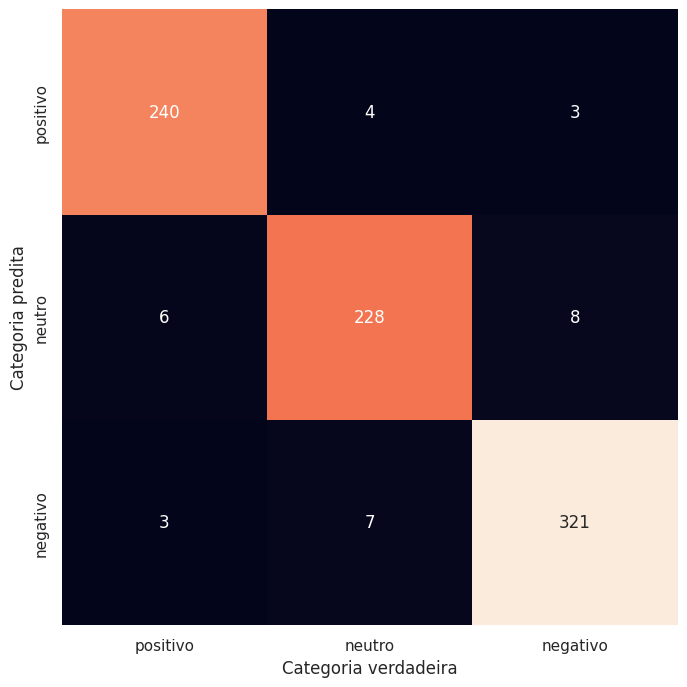

In [172]:
# 8. Predizer e avaliar
rotulos_preditos = sent_clf.predict(corpus_teste)
print(classification_report(rotulos_teste, rotulos_preditos))

# 9. Matriz de confusão
mat = confusion_matrix(rotulos_teste, rotulos_preditos)
plt.figure(figsize=(8, 8))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['positivo', 'neutro', 'negativo'],
            yticklabels=['positivo', 'neutro', 'negativo'])
plt.xlabel('Categoria verdadeira')
plt.ylabel('Categoria predita')
plt.show()

In [177]:

# Exemplo de palavras-chave para classificar os sentimentos
palavras_positivas = ['bom', 'ótimo', 'excelente', 'feliz', 'alegria', 'correto', 'bueno', 'good','risa']
palavras_negativas = ['ruim', 'triste', 'raiva', 'desgosto', 'medo','errado','malo','horrible']

def classificar_sentimento(texto):
    texto = texto.lower()  # Para facilitar a comparação
    if any(palavra in texto for palavra in palavras_positivas):
        return 'positivo'
    elif any(palavra in texto for palavra in palavras_negativas):
        return 'negativo'
    else:
        return 'neutro'

# Aplicar a função de classificação à coluna 'Text'
df['sentimento'] = df['Text'].apply(classificar_sentimento)

# Verificando o DataFrame
print(df[['Text', 'sentimento']].head())

                                                Text sentimento
0  ���⛪ @ Catedral de Santo Antônio - Governador ...     neutro
1  � @ Governador Valadares, Minas Gerais https:/...     neutro
2  �� @ Governador Valadares, Minas Gerais https:...     neutro
3                        ��� https://t.co/BnDsO34qK0     neutro
4  ��� PSOL vai questionar aumento de vereadores ...     neutro


In [178]:
# Contar a quantidade de cada sentimento
qtdeTweetsPos = len(df[df['sentimento'] == 'positivo'])
qtdeTweetsNeg = len(df[df['sentimento'] == 'negativo'])
qtdeTweetsNeu = len(df[df['sentimento'] == 'neutro'])

# Calcular as porcentagens
total_tweets = len(df)

print("POSITIVOS: {:.2f}%".format(100 * qtdeTweetsPos / total_tweets))
print("NEGATIVOS: {:.2f}%".format(100 * qtdeTweetsNeg / total_tweets))
print("NEUTROS: {:.2f}%".format(100 * qtdeTweetsNeu / total_tweets))


POSITIVOS: 1.43%
NEGATIVOS: 0.21%
NEUTROS: 98.37%


script adicional Atividade complementar
Você pode deixar o algoritmo mais robusto, ao treinar um classificador utilizando as bases rotuladas de tweets em português, listadas nas referências deste notebook.

In [218]:
!pip install spellchecker nltk

In [183]:
ex!pip install pyspellchecker


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 35.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from spellchecker import SpellChecker

In [201]:



# conversion de giria en variavel
def substituir_girias(texto):
    girias = {
        'vc': 'você',
        'tb': 'também',
        'pq': 'porque',
        'q': 'que',
        'mlk': 'menino',
        'xd': '',

    }
    for g, p in girias.items():
        texto = texto.replace(g, p)
    return texto



In [193]:
# Função para contar a presença de emojis
def contar_emojis(texto):
    emojis = re.findall(r'[^\w\s,]', texto)  # Captura símbolos não alfanuméricos
    return len(emojis)

# Função para contar a presença de hashtags
def contar_hashtags(texto):
    return len(re.findall(r'#\w+', texto))

# Função para pré-processamento
def preprocessamento(texto):
    texto = texto.lower()
    texto = substituir_girias(texto)
    texto = re.sub(r'http\S+|www\S+|https\S+', '', texto)  # Remove hiperlinks
    texto = re.sub(r'@\w+', '', texto)  # Remove menções
    texto = re.sub(r'#[^\s]+', '', texto)  # Remove hashtags
    texto = re.sub(r'[^\w\s]', '', texto)  # Remove pontuações
    return texto



In [208]:
# 1. Carregar os dados (ajuste o caminho para o seu arquivo)
df = pd.read_csv('Tweets_Mg.csv')




In [209]:
# 2. Aplicar o pré-processamento ao texto
df['Texto Limpo'] = df['Text'].apply(preprocessamento)



In [210]:
# 3. Criar features adicionais
df['Contagem Emojis'] = df['Text'].apply(contar_emojis)
df['Contagem Hashtags'] = df['Text'].apply(contar_hashtags)



In [211]:
# 4. Dividir os dados
X = df[['Texto Limpo', 'Contagem Emojis', 'Contagem Hashtags']]
y = df['Classificacao']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [212]:
# 5. Vetorização com TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train['Texto Limpo'])
X_test_tfidf = vectorizer.transform(X_test['Texto Limpo'])

# 6. Adicionar contagens de emojis e hashtags às features
import scipy
X_train_combined = scipy.sparse.hstack((X_train_tfidf, X_train[['Contagem Emojis', 'Contagem Hashtags']].values))
X_test_combined = scipy.sparse.hstack((X_test_tfidf, X_test[['Contagem Emojis', 'Contagem Hashtags']].values))



In [213]:
# 7. Treinar o classificador
classifier = MultinomialNB()
classifier.fit(X_train_combined, y_train)



MultinomialNB()

In [214]:
# 8. Avaliar o modelo
y_pred = classifier.predict(X_test_combined)

# Matriz de Confusão
print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred))


Matriz de Confusão:
[[458  14   4]
 [ 23 418  62]
 [  2  11 648]]


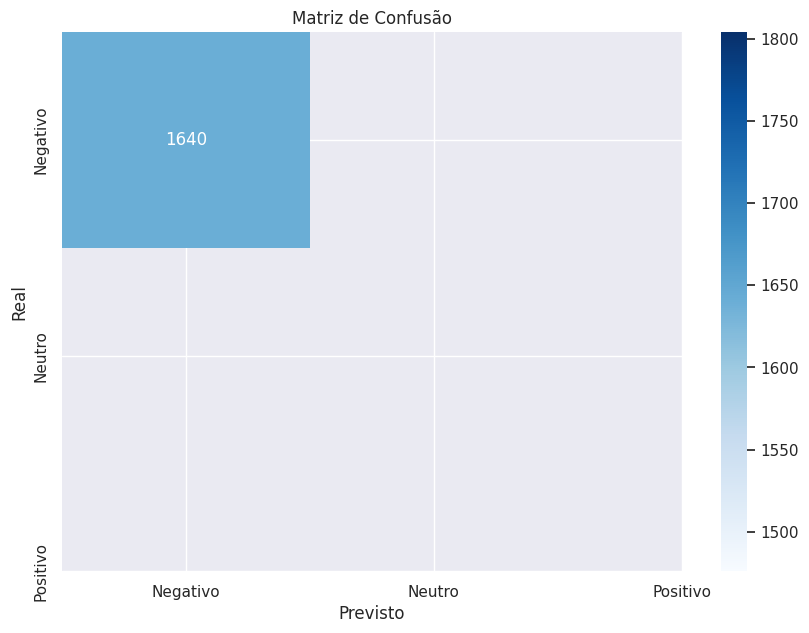


Relatório de Classificação:
              precision    recall  f1-score   support

    Negativo       0.95      0.96      0.96       476
      Neutro       0.94      0.83      0.88       503
    Positivo       0.91      0.98      0.94       661

    accuracy                           0.93      1640
   macro avg       0.93      0.92      0.93      1640
weighted avg       0.93      0.93      0.93      1640



In [215]:
# Visualização da Matriz de Confusão
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negativo', 'Neutro', 'Positivo'], yticklabels=['Negativo', 'Neutro', 'Positivo'])
plt.ylabel('Real')
plt.xlabel('Previsto')
plt.title('Matriz de Confusão')
plt.show()
# Relatório de Classificação
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))



In [216]:
# Calcular as porcentagens
qtdeTweetsPos = sum(y_pred == 'positivo')
qtdeTweetsNeg = sum(y_pred == 'negativo')
qtdeTweetsNeu = sum(y_pred == 'neutro')

print("\nPorcentagens de Sentimentos:")
print("POSITIVOS: {}%".format(100 * qtdeTweetsPos / len(y_test)))
print("NEGATIVOS: {}%".format(100 * qtdeTweetsNeg / len(y_test)))
print("NEUTROS: {}%".format(100 * qtdeTweetsNeu / len(y_test)))



Porcentagens de Sentimentos:
POSITIVOS: 0.0%
NEGATIVOS: 0.0%
NEUTROS: 0.0%


https://www.kaggle.com/code/rodmnzs/an-lise-de-sentimento-no-twitter-nlp?kernelSessionId=122466740

adicionais
modelo achado em github e testado , mas para adicionar emojis iria ser um pouco mais extenso *texto em itálico*

https://github.com/kweweli/AI